In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [27]:
directory = 'Dillards_POS/'
skst_file_path = directory + 'skstinfo.csv'
trans_file_path = directory + 'trans.csv'
str_file_path = directory + 'strinfo.csv'

In [3]:
def prepare_basket(trans_file_path, skst_file_path):
    ''' function that prepares basket from the transaction table'''
    
    # Transaction table
    trans = pd.read_csv(trans_file_path)
    trans.columns = ['sku', 'storeid', 'register', 'trannum', 'interID', 'saledate', 'stype', 'quantity',
                 'orgprice', 'amt', 'seq', 'mic', 'unkown']
    # Drop all returns
    trans = trans[trans['stype'] == 'P']
    
    # Drop columns irrelevant to basket
    trans.drop(columns=['interID', 'stype', 'mic', 'unkown'], inplace=True)
    
    # skst table
    skst = pd.read_csv(skst_file_path, header = None)
    skst.columns = ['sku', 'storeid', 'cost', 'retail', 'unknown']
    
    # Drop columns irrelevant to basket
    skst.drop(columns = ['unknown'], inplace=True)
    
    # Get non zero mean retail for each sku
    mean_retail = skst.groupby('sku')['retail'].unique().reset_index()
    mean_retail['retail'] = mean_retail['retail'].apply(
        lambda x: sum(x) / len(x) if len(x) > 0 else 0 if len([i for i in x if i != 0]) > 0 else 0
    )
    mean_retail = mean_retail.set_index('sku')
    mean_retail_series = mean_retail['retail']
    
    # Merge transaction and skst
    trans = pd.merge(trans, skst, on=['sku','storeid'], how='left')
    
    # Fill NaN values in 'retail' with the mean retail
    trans['retail'] = trans['retail'].fillna(trans['sku'].map(mean_retail_series))
    # Fill NaN values in 'retail' with the corresponding 'orgprice' values
    trans['retail'] = trans['retail'].fillna(trans['orgprice'])
    
    # Fill NaN values in 'orgprice' with the mean retail
    trans['orgprice'] = trans['orgprice'].fillna(trans['sku'].map(mean_retail_series))
    
    
    # Feature engineering
    
    trans['saledate'] = pd.to_datetime(trans['saledate'])
    # day of week as a number (Monday=0, Sunday=6)
    trans['day_of_week'] = trans['saledate'].dt.dayofweek
    # month as a number
    trans['month'] = trans['saledate'].dt.month
    # Define weekend as Friday (4) to Sunday (6)
    trans['weekend'] = trans['day_of_week'].apply(lambda x: 1 if x >= 4 else 0)
    
    # percent discount calculated with (retail - amt) / retail
    trans['percent_discount'] = np.where(
        (trans['orgprice'] > trans['amt']) & ~np.isnan(trans['orgprice']) & ~np.isnan(trans['amt']),
        (trans['orgprice'] - trans['amt']) / trans['orgprice'],
        0
    )
    # final sale defined as > 50% descount
    trans['final_sale'] = np.where(trans['percent_discount']>0.5, 1, 0)
    return trans

In [4]:
df = prepare_basket(trans_file_path, skst_file_path)
df = df[df['sku'] == 6732960]
df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale
76882644,6732960,102,70,7300,2004-12-22,1,40.0,40.00,744600042,24.0,40.0,2,12,0,0.0000,0
76882645,6732960,102,70,7300,2004-12-22,1,40.0,40.00,744700042,24.0,40.0,2,12,0,0.0000,0
76882646,6732960,102,120,4000,2004-10-30,1,40.0,15.98,68800026,24.0,40.0,5,10,1,0.6005,1
76882647,6732960,102,120,4000,2004-10-30,1,40.0,15.98,68900026,24.0,40.0,5,10,1,0.6005,1
76882648,6732960,102,120,4000,2004-10-30,1,40.0,15.98,69000026,24.0,40.0,5,10,1,0.6005,1


In [21]:
df.shape

(5093, 16)

In [6]:
storeid_discount_changes = df.groupby('storeid')['percent_discount'].nunique()
storeids_with_changes = storeid_discount_changes[storeid_discount_changes > 1].index
storeids_with_changes

Index([ 102,  103,  107,  203,  204,  209,  302,  303,  304,  307,
       ...
       9204, 9302, 9304, 9309, 9409, 9503, 9704, 9804, 9806, 9909],
      dtype='int64', name='storeid', length=215)

In [7]:
df_filtered = df[df['storeid'].isin(storeids_with_changes)]

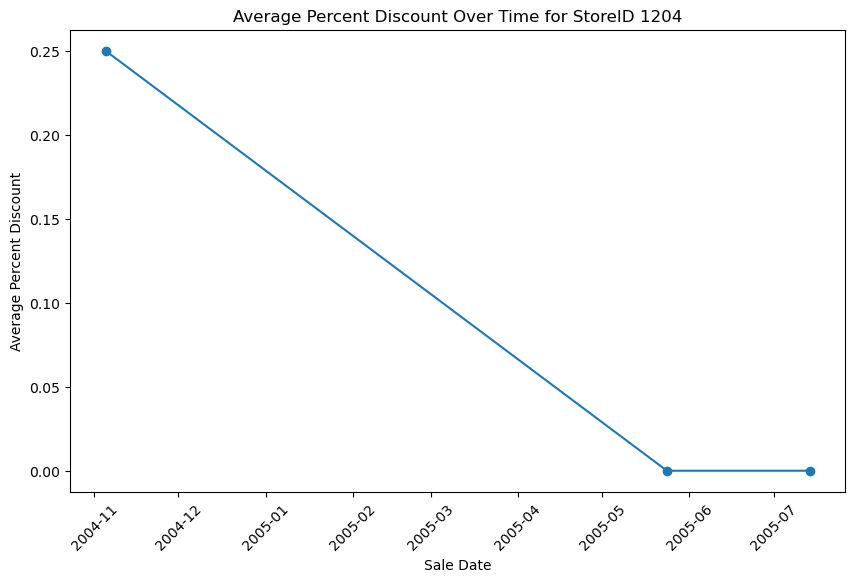

In [67]:
store_1204_discounts = df_filtered[df_filtered['storeid'] == 1204].groupby('saledate')['percent_discount'].mean()
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(store_1204_discounts.index, store_1204_discounts, marker='o', linestyle='-')  # Plot with markers

plt.title('Average Percent Discount Over Time for StoreID 1204')
plt.xlabel('Sale Date')
plt.ylabel('Average Percent Discount')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()


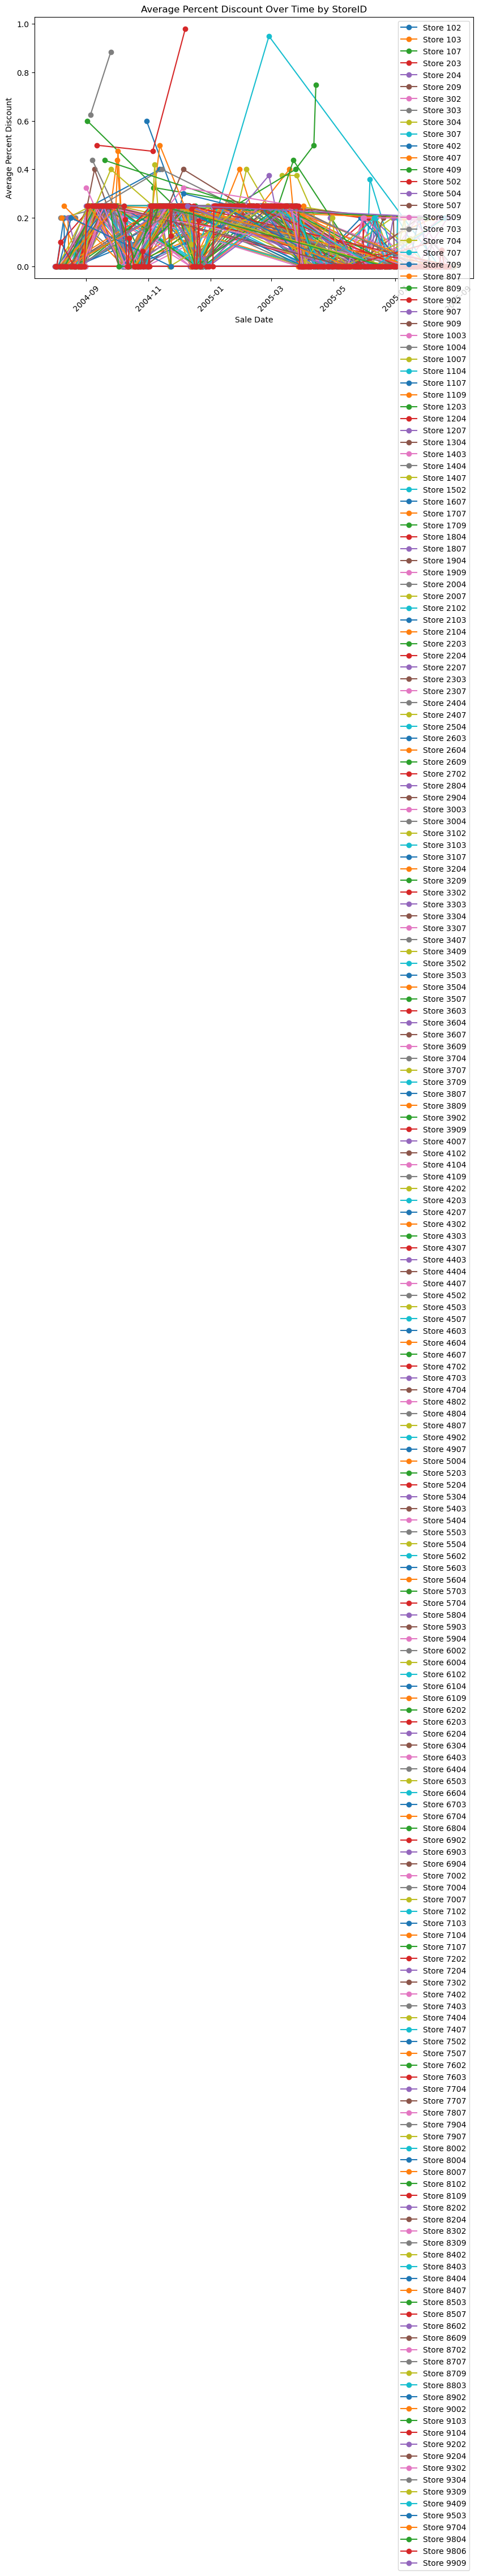

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for storeid in df_filtered['storeid'].unique():
    store_df = df_filtered[df_filtered['storeid'] == storeid]
    avg_discounts = store_df.groupby('saledate')['percent_discount'].mean()
    
    plt.plot(avg_discounts.index, avg_discounts, marker='o', linestyle='-', label=f'Store {storeid}')

plt.title('Average Percent Discount Over Time by StoreID')
plt.xlabel('Sale Date')
plt.ylabel('Average Percent Discount')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()

plt.show()



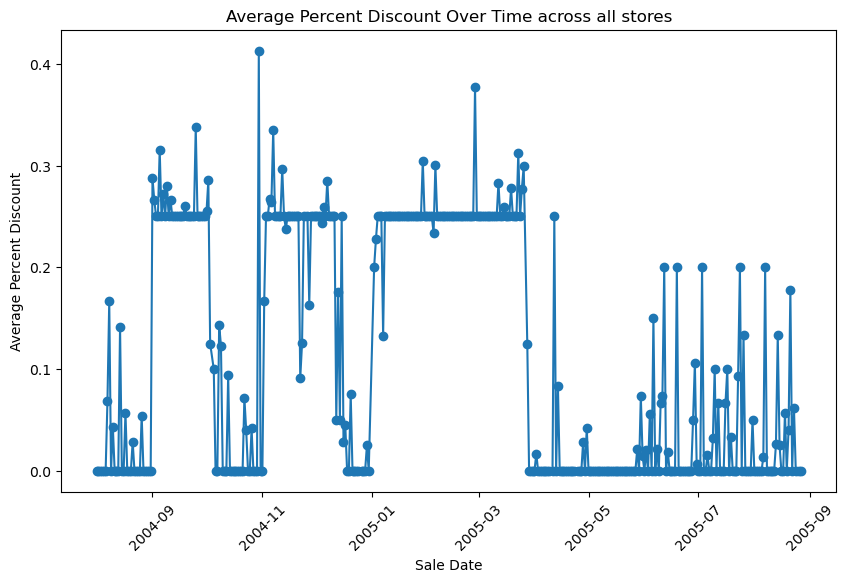

In [10]:
discounts = df.groupby('saledate')['percent_discount'].mean()
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(discounts.index, discounts, marker='o', linestyle='-')  # Plot with markers

plt.title('Average Percent Discount Over Time across all stores')
plt.xlabel('Sale Date')
plt.ylabel('Average Percent Discount')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()



In [13]:
mean_discount_by_date = df.groupby('saledate')['percent_discount'].mean()
count_seq_by_date = df.groupby('saledate')['seq'].size()
merged_df = pd.merge(mean_discount_by_date, count_seq_by_date, left_index=True, right_index=True)
merged_df.columns = ['mean_percent_discount', 'sales']
merged_df

,mean_percent_discount,sales
saledate,,
2004-08-01,0.000000,4
2004-08-02,0.000000,10
2004-08-03,0.000000,9
2004-08-04,0.000000,2
2004-08-05,0.000000,4
...,...,...
2005-08-22,0.000000,4
2005-08-23,0.061538,13
2005-08-24,0.000000,3


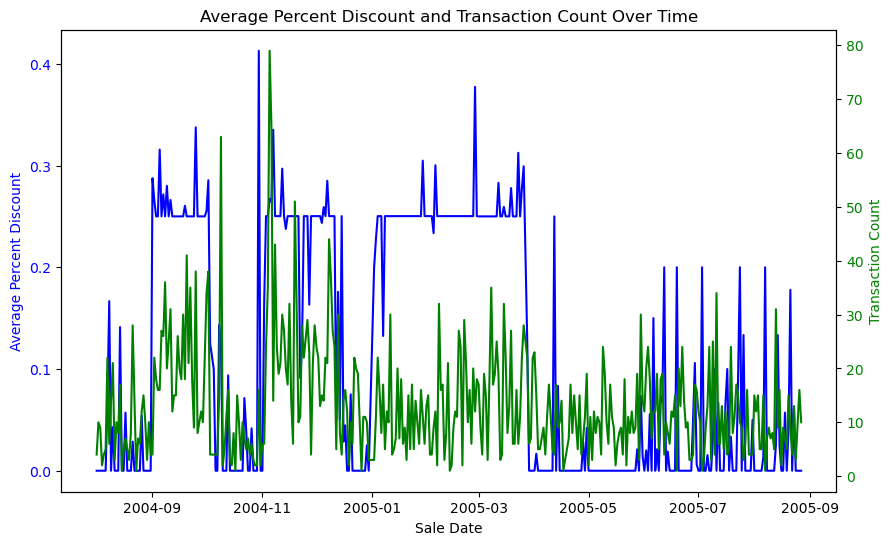

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create the first y-axis for mean_percent_discount
ax1 = plt.gca()
ax1.plot(merged_df.index, merged_df['mean_percent_discount'], color='blue', label='Average Percent Discount')
ax1.set_xlabel('Sale Date')
ax1.set_ylabel('Average Percent Discount', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for seq_count
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(merged_df.index, merged_df['sales'], color='green', label='Transaction Count')
ax2.set_ylabel('Transaction Count', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Average Percent Discount and Transaction Count Over Time')

# Show the plot
plt.show()


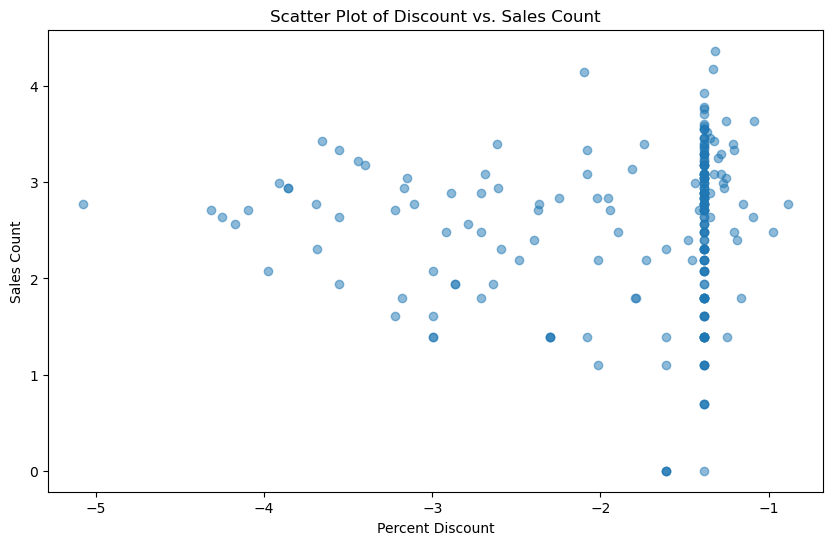

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log(merged_df['mean_percent_discount']), np.log(merged_df['sales']), alpha=0.5)

plt.title('Scatter Plot of Discount vs. Sales Count')
plt.xlabel('Percent Discount')
plt.ylabel('Sales Count')

plt.show()

In [28]:
strinfo = pd.read_csv(str_file_path, header = None)
strinfo.columns = ['storeid', 'city', 'state', 'zip', 'unknown']
strinfo.drop(columns=['unknown'], inplace=True)
strinfo

,storeid,city,state,zip
0,2,ST. PETERSBURG,FL,33710
1,3,ST. LOUIS,MO,63126
2,4,LITTLE ROCK,AR,72201
3,7,FORT WORTH,TX,76137
4,9,TEMPE,AZ,85281
...,...,...,...,...
448,9808,GILBERT,AZ,85233
449,9812,METAIRIE,LA,70006
450,9900,LITTLE ROCK,AR,72201
451,9906,LITTLE ROCK,AR,72201


In [29]:
joined_df = pd.merge(df, strinfo, on='storeid', how='inner')
joined_df

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,city,state,zip
0,6732960,102,70,7300,2004-12-22,1,40.0,40.00,744600042,24.0,40.0,2,12,0,0.00000,0,TAMPA,FL,33607
1,6732960,102,70,7300,2004-12-22,1,40.0,40.00,744700042,24.0,40.0,2,12,0,0.00000,0,TAMPA,FL,33607
2,6732960,102,120,4000,2004-10-30,1,40.0,15.98,68800026,24.0,40.0,5,10,1,0.60050,1,TAMPA,FL,33607
3,6732960,102,120,4000,2004-10-30,1,40.0,15.98,68900026,24.0,40.0,5,10,1,0.60050,1,TAMPA,FL,33607
4,6732960,102,120,4000,2004-10-30,1,40.0,15.98,69000026,24.0,40.0,5,10,1,0.60050,1,TAMPA,FL,33607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5088,6732960,9909,770,1400,2005-08-23,1,40.0,32.00,20700016,24.0,40.0,1,8,0,0.20000,0,CHEYENNE,WY,82009
5089,6732960,9909,770,1400,2005-08-23,1,40.0,32.00,20800016,24.0,40.0,1,8,0,0.20000,0,CHEYENNE,WY,82009
5090,6732960,9909,770,1400,2005-08-23,1,40.0,32.00,20900016,24.0,40.0,1,8,0,0.20000,0,CHEYENNE,WY,82009
5091,6732960,9909,770,2100,2004-12-09,1,40.0,29.99,531600025,24.0,40.0,3,12,0,0.25025,0,CHEYENNE,WY,82009


In [35]:
sales_quantity = joined_df.groupby(['day_of_week', 'month', 'state']).size().reset_index(name='quantity')
mean_discount = joined_df.groupby(['day_of_week', 'month', 'state'])['percent_discount'].mean().reset_index(name='mean_discount')
merged = pd.merge(mean_discount, sales_quantity, on = ['day_of_week', 'month', 'state'])
merged

,day_of_week,month,state,mean_discount,quantity
0,0,1,AL,0.250250,2
1,0,1,AR,0.238875,22
2,0,1,AZ,0.250250,4
3,0,1,FL,0.250250,4
4,0,1,IL,0.250250,1
...,...,...,...,...,...
917,6,12,MO,0.250000,1
918,6,12,NC,0.000000,1
919,6,12,NE,0.000000,1
920,6,12,TX,0.135786,7


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df is your DataFrame
# One-Hot Encode the 'state' column
df_encoded = pd.get_dummies(merged, columns=['state'], drop_first=True)

# Split the data into features and target
X = df_encoded.drop('quantity', axis=1)
y = df_encoded['quantity']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
# Create a Gradient Boosting Regressor model
gbr = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gbr.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [43]:
# Make predictions on the test set
y_pred = gbr.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 38.612452760325645
R-squared: 0.49898463424779893


In [44]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Create a Gradient Boosting Regressor model
gbr = GradientBoostingRegressor(random_state=42)

# Setup Grid Search
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [48]:
best_params = grid_search.best_params_  # or random_search.best_params_ if using RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Create a new model instance with the best parameters
optimized_gbr = GradientBoostingRegressor(**best_params)
# Fit the model
optimized_gbr.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test set
y_pred = optimized_gbr.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 39.03411097676265
R-squared: 0.4935134136847874
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimat

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3

In [54]:
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Create a DataFrame that combines y_test and y_pred
comparison_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_series})

# Print the DataFrame
comparison_df.head(20)

,y_test,y_pred
319,3,2.033664
377,4,4.426030
538,11,4.195646
296,3,2.264280
531,1,2.834803
70,2,3.069617
493,1,5.300995
664,9,12.881917
798,3,3.805979
30,1,1.277704


In [58]:
comparison_df['diff'] = (comparison_df['y_test'] - comparison_df['y_pred'])
comparison_df['abs_diff'] = abs(comparison_df['diff'])
comparison_df['relative_diff'] = abs(comparison_df['y_test'] - comparison_df['y_pred'])/comparison_df['y_test']
comparison_df.head(20)

,y_test,y_pred,diff,abs_diff,relative_diff
319,3,2.033664,0.966336,0.966336,0.322112
377,4,4.426030,-0.426030,0.426030,0.106508
538,11,4.195646,6.804354,6.804354,0.618578
296,3,2.264280,0.735720,0.735720,0.245240
531,1,2.834803,-1.834803,1.834803,1.834803
70,2,3.069617,-1.069617,1.069617,0.534808
493,1,5.300995,-4.300995,4.300995,4.300995
664,9,12.881917,-3.881917,3.881917,0.431324
798,3,3.805979,-0.805979,0.805979,0.268660
30,1,1.277704,-0.277704,0.277704,0.277704


<Axes: >

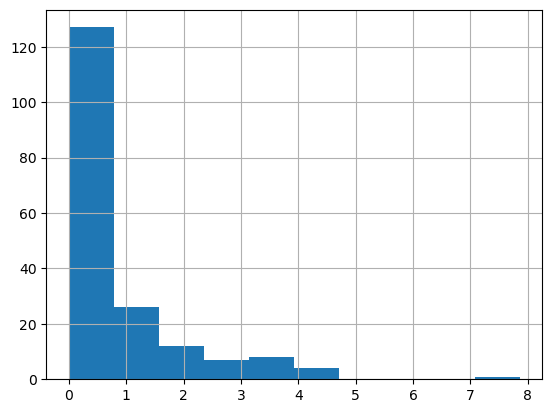

In [59]:
comparison_df['relative_diff'].hist()

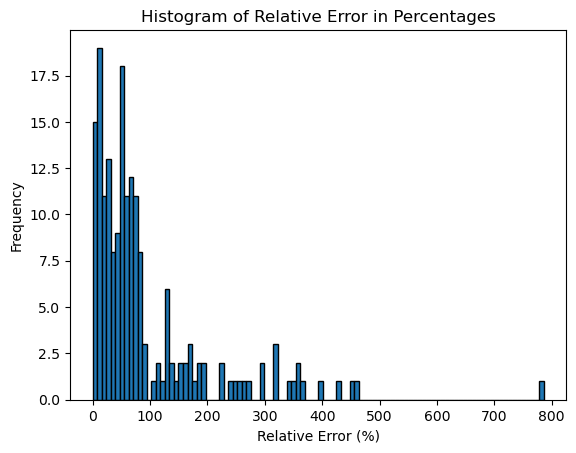

In [62]:
import pandas as pd

# Assuming y_test and y_pred are already defined
relative_error = abs((y_pred - y_test) / y_test) * 100
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(relative_error, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Error in Percentages')
plt.show()
